In [1]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable


c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=False)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [3]:

model=VGGNet()
model.load_state_dict(torch.load("VGG16_0809_91.pt"))
model.to("cuda")

c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\HZT\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGGNet(
  (features): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [4]:
transform2=transforms.Compose([
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #标准化至[-1,1]
])

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=False)


In [5]:

loss_list = []
accuracy_list = []

y_true=[]
y_pred=[]
loss_func = nn.CrossEntropyLoss()

model.eval()
eval_loss = 0.
eval_acc = 0.
for img, label in val_dataloader:
    img = Variable(img).cuda()
    label = Variable(label).cuda()
    out = model(img)
    loss = loss_func(out, label)
    eval_loss += loss.item()
    pred = torch.max(out, 1)[1]
    num_correct = (pred == label).sum()
    eval_acc += num_correct.item()

    y_true.extend(label.cpu().tolist())
    y_pred.extend(pred.cpu().tolist())
print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))

loss_list.append(eval_loss / (len(val_datasets)))
accuracy_list.append(100 * eval_acc / (len(val_datasets)))

Test Loss: 0.033392, Acc: 0.910000


In [6]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

In [7]:

tp=cm[0][0]
fn=cm[0][1]
fp=cm[1][0]
tn=cm[1][1]
print("Accuracy:",(tp+tn)/1000 )

p_presicion=tp/(tp+fp)
p_recall=tp/(tp+fn)
print('FIT precision:',p_presicion)
print('FIT recall:',p_recall)

n_presicion=tn/(tn+fn)
n_recall=tn/(fp+tn)
print('n_FIT precision:',n_presicion)
print('n_FIT recall:',n_recall)

print("F1",(2*p_presicion*p_recall)/(p_presicion+p_recall))

Accuracy: 0.91
FIT precision: 0.9235537190082644
FIT recall: 0.894
n_FIT precision: 0.8972868217054264
n_FIT recall: 0.926
F1 0.9085365853658537


[0.    0.106 1.   ] [0.    0.926 1.   ] [2 1 0]


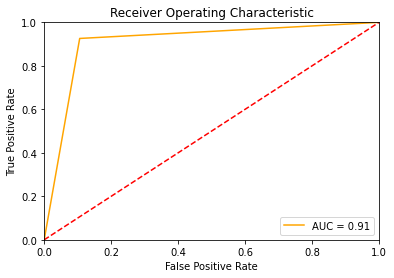

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_true, y_pred)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

In [9]:
auc1

0.91